In [27]:
import pickle
import numpy as np
from PIL import Image
import os
import albumentations as A
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load Data
with open('../Data/processed_train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
    
with open('../Data/processed_test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [4]:
def prepare_data(data):
    x=[]
    y=[]
    label_map={}
    
    for i, class_name in enumerate(data.keys()):
        label_map[class_name] = i

        for image in data[class_name]:
            try:
                with Image.open(image) as img:
                    img_array = np.array(img)
                    x.append(img_array)
                    y.append(label_map[class_name])
            except Exception as e:
                print(f"Error loading image {image}: {e}")
                continue


    x = np.array(x)
    y = np.array(y)

    return x, y, label_map
    

x_train, y_train, label_map_train = prepare_data(train_data)
x_test, y_test, label_map_test = prepare_data(test_data)

print(x_train.shape)
print(y_train.shape)
print(label_map_train)

print(x_test.shape)
print(y_test.shape)
print(label_map_test)

print(x_train[0])
print(y_train[0])

print(x_test[0])
print(y_test[0])

(24499, 84, 84, 3)
(24499,)
{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}
(800, 84, 84, 3)
(800,)
{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}
[[[237 144 165]
  [232 140 161]
  [228 140 162]
  ...
  [232 139 157]
  [236 148 164]
  [245 161 176]]

 [[236 143 164]
  [232 140 161]
  [227 139 161]
  ...
  [232 139 157]
  [241 150 167]
  [250 166 181]]

 [[238 145 166]
  [237 145 166]
  [233 145 167]
  ...
  [237 143 161]
  [247 156 173]
  [255 168 184]]

 ...

 [[227 137 147]
  [231 138 149]
  [233 132 146]
  ...
  [236 134 130]
  [234 132 127]
  [231 130 122]]

 [[227 137 147]
  [230 137 148]
  [232 131 145]
  ...
  [237 135 131]
  [234 132 127]
  [232 131 123]]

 [[229 137 148]
  [233 137 149]
  [234 132 146]
  ...
  [239 140 135]
  [237 138 132]
  [237 136 128]]]
0
[[[108  89  82]
  [116  97  90]
  [126 106  99]
  ...
  [209 185 185]
  [205 181 181]
  [202 178 178]]

 [[117  98  91]
  [123 104  97]
  [130 110 103]
  ...


### Data Augmentation ###

In [33]:
# Define the augmentation pipeline
transform = A.Compose([
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(blur_limit=3, p=0.5),
    A.GridDropout(ratio=0.3, p=0.5),
])

# Define the minor and major classes
minor_classes = [0, 1, 2, 3, 4, 6, 7]
minor_class_indices = np.where(np.isin(y_train, minor_classes))[0]
major_class_indices = np.where(~np.isin(y_train, minor_classes))[0]

print(f"Number of minor class samples: {len(minor_class_indices)}")
print(f"Number of major class samples: {len(major_class_indices)}")



Number of minor class samples: 11724
Number of major class samples: 12775


In [34]:
# Create a new dataset with augmented samples
new_x_train = [x_train[i] for i in major_class_indices]
new_y_train = [y_train[i] for i in major_class_indices]

print(len(new_x_train))

target_size = 4000

for class_name in minor_classes:
    class_indices = np.where(y_train == class_name)[0]
    original_size = len(class_indices)
    need_to_augment = target_size - original_size

    print(f"Original size: {original_size}, target size: {target_size}")

    for i in tqdm(class_indices, desc="Adding original samples"):
        image = x_train[i]
        label = y_train[i]

        # Keep original image and generate augmented images until target size is reached
        new_x_train.append(image)
        new_y_train.append(label)


    # Augment the dataset until the target size is reached
    with tqdm(total=need_to_augment, desc="Augmenting samples") as pbar:
        while need_to_augment > 0:
            sample = x_train[np.random.choice(class_indices)]
            augmented = transform(image=sample)['image']
            new_x_train.append(augmented)
            new_y_train.append(label)
            need_to_augment -= 1

            pbar.update(1)

print(f"New dataset size: {len(new_x_train)}")



12775
Original size: 735, target size: 4000


Augmenting samples: 100%|██████████| 3265/3265 [00:04<00:00, 762.60it/s] 


Original size: 3223, target size: 4000


Augmenting samples: 100%|██████████| 777/777 [00:00<00:00, 1107.91it/s]


Original size: 2524, target size: 4000


Augmenting samples: 100%|██████████| 1476/1476 [00:00<00:00, 1706.15it/s]


Original size: 139, target size: 4000


Augmenting samples: 100%|██████████| 3861/3861 [00:01<00:00, 2004.51it/s]


Original size: 4422, target size: 4000


Adding original samples: 100%|██████████| 4422/4422 [00:00<?, ?it/s]
Augmenting samples: 0it [00:00, ?it/s]


Original size: 528, target size: 4000


Augmenting samples: 100%|██████████| 3472/3472 [00:01<00:00, 1822.64it/s]


Original size: 153, target size: 4000


Augmenting samples: 100%|██████████| 3847/3847 [00:01<00:00, 2129.68it/s]

New dataset size: 41197


In [16]:
# Normalize data
new_x_train = np.array(new_x_train)
new_y_train = np.array(new_y_train)

new_x_train = new_x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
num_classes = len(label_map_train)
new_y_train_cat = tf.keras.utils.to_categorical(new_y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

In [19]:
model = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=new_x_train.shape[1:], kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    
    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.7),
    layers.Dense(num_classes, activation='softmax')

])

c:\Users\mande\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Define callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

In [22]:
history = model.fit(
    new_x_train, new_y_train_cat,
    epochs=30,
    batch_size=128,
    validation_data=(x_test, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

test_loss, test_acc = model.evaluate(x_test, y_test_cat)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

Epoch 1/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.3531 - loss: 3.7153 - val_accuracy: 0.1575 - val_loss: 6.9902 - learning_rate: 0.0010
Epoch 2/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.4776 - loss: 2.5363 - val_accuracy: 0.2675 - val_loss: 4.0310 - learning_rate: 0.0010
Epoch 3/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.5164 - loss: 2.1362 - val_accuracy: 0.2188 - val_loss: 4.0569 - learning_rate: 0.0010
Epoch 4/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.5486 - loss: 2.0105 - val_accuracy: 0.2438 - val_loss: 3.9713 - learning_rate: 0.0010
Epoch 5/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.5655 - loss: 2.0006 - val_accuracy: 0.3700 - val_loss: 2.4743 - learning_rate: 0.0010
Epoch 6/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.5956 - loss: 1.9269 - val_accuracy: 0.3262 - val_loss: 2.8329 - learning_rate: 0.0010
Epoch 7/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - accuracy: 0.6125 - loss: 1.

x_test shape: (800, 84, 84, 3)
y_test shape: (800, 8)
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
y_pred shape: (800, 8)
Classification Report:
                               precision    recall  f1-score   support

       Actinic Keratosis (AK)       0.12      1.00      0.22       100
   Basal Cell Carcinoma (BCC)       0.00      0.00      0.00       100
       Benign Keratosis (BKL)       0.00      0.00      0.00       100
          Dermatofibroma (DF)       0.00      0.00      0.00       100
               Melanoma (MEL)       0.00      0.00      0.00       100
       Melanocytic Nevus (NV)       0.00      0.00      0.00       100
Squamous Cell Carcinoma (SCC)       0.00      0.00      0.00       100
       Vascular Lesion (VASC)       0.00      0.00      0.00       100

                     accuracy                           0.12       800
                    macro avg       0.02      0.12      0.03       800
                 weighted avg       0.02      0.12      0.03       800

ROC-A

c:\Users\mande\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mande\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mande\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


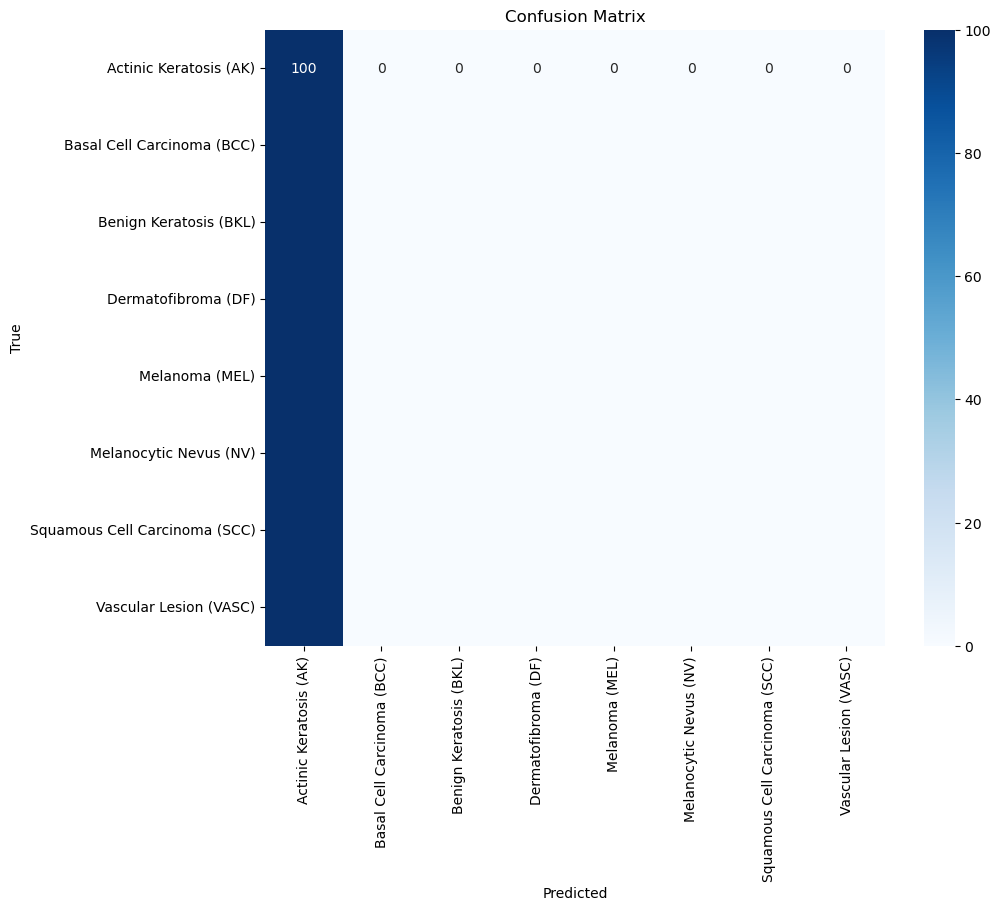

In [27]:
print("x_test shape:", x_test.shape)  # Expected: (800, 84, 84, 3) or similar
print("y_test shape:", y_test.shape)  # Expected: (800, 8) for one-hot, or (800,) for integer labels

# Preprocess x_test (ensure normalization and correct shape)
x_test = x_test.astype('float32') / 255.0  # Normalize to [0, 1]
# If model expects different size (e.g., 84x84), resize if needed
# x_test = tf.image.resize(x_test, [84, 84]).numpy()

# Check if y_test is one-hot encoded; convert if integer labels
if len(y_test.shape) == 1 or y_test.shape[1] == 1:
    print("Converting y_test to one-hot encoded format")
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=8)

# Generate predictions
try:
    y_pred = model.predict(x_test)
    print("y_pred shape:", y_pred.shape)  # Expected: (800, 8)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
except Exception as e:A
    print(f"Error in prediction: {e}")
    raise

# Classification report
class_names = [
    'Actinic Keratosis (AK)',
    'Basal Cell Carcinoma (BCC)',
    'Benign Keratosis (BKL)',
    'Dermatofibroma (DF)',
    'Melanoma (MEL)',
    'Melanocytic Nevus (NV)',
    'Squamous Cell Carcinoma (SCC)',
    'Vascular Lesion (VASC)'
]
print("Classification Report:")
try:
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))
except Exception as e:
    print(f"Error in classification report: {e}")
    raise

# ROC-AUC score
try:
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    print(f"ROC-AUC (One-vs-Rest): {roc_auc:.4f}")
except ValueError as e:
    print(f"ROC-AUC calculation failed: {e}")

# Confusion Matrix Heatmap (for report)
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)  # Save for report
plt.show()

## New Implement ##
### Result still bad, try to improve the pre-process and use transfer learning ###

In [5]:
# Define the augmentation pipeline
transform = A.Compose([
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(blur_limit=3, p=0.5),
    A.GridDropout(ratio=0.3, p=0.5),
])

# Define the minor and major classes
minor_classes = [0, 2, 3, 6, 7]
minor_class_indices = np.where(np.isin(y_train, minor_classes))[0]
major_class_indices = np.where(~np.isin(y_train, minor_classes))[0]

print(f"Number of minor class samples: {len(minor_class_indices)}")
print(f"Number of major class samples: {len(major_class_indices)}")



Number of minor class samples: 4079
Number of major class samples: 20420


In [6]:
# Create a new dataset with augmented samples
new_x_train = [x_train[i] for i in major_class_indices]
new_y_train = [y_train[i] for i in major_class_indices]

print(len(new_x_train))

target_size = 3000 #4000 maybe too many for those rare classes, dont want to have fake data

for class_name in minor_classes:
    class_indices = np.where(y_train == class_name)[0]
    original_size = len(class_indices)
    need_to_augment = target_size - original_size

    print(f"Original size: {original_size}, target size: {target_size}")

    for i in tqdm(class_indices, desc="Adding original samples"):
        image = x_train[i]
        label = y_train[i]

        # Keep original image and generate augmented images until target size is reached
        new_x_train.append(image)
        new_y_train.append(label)


    # Augment the dataset until the target size is reached
    with tqdm(total=need_to_augment, desc="Augmenting samples") as pbar:
        while need_to_augment > 0:
            sample = x_train[np.random.choice(class_indices)]
            augmented = transform(image=sample)['image']
            new_x_train.append(augmented)
            new_y_train.append(label)
            need_to_augment -= 1

            pbar.update(1)

print(f"New dataset size: {len(new_x_train)}")



20420
Original size: 735, target size: 3000


Adding original samples: 100%|██████████| 735/735 [00:00<?, ?it/s]


Augmenting samples: 100%|██████████| 2265/2265 [00:00<00:00, 2677.89it/s]


Original size: 2524, target size: 3000


Augmenting samples: 100%|██████████| 476/476 [00:00<00:00, 2066.66it/s]


Original size: 139, target size: 3000


Augmenting samples: 100%|██████████| 2861/2861 [00:01<00:00, 2630.61it/s]


Original size: 528, target size: 3000


Augmenting samples: 100%|██████████| 2472/2472 [00:01<00:00, 2358.84it/s]


Original size: 153, target size: 3000


Augmenting samples: 100%|██████████| 2847/2847 [00:01<00:00, 2258.91it/s]

New dataset size: 35420


### Pre-process for Transfer learning(EffiecntNet) ###

In [43]:
# Pre-process(resize the image to 224x224)

def preprocess_image(image, label):
    image = tf.image.resize(image, [224,224])
    image = preprocess_input(image)
    return image, label

# Change training data to tf.dataset
new_x_train = np.array(new_x_train)
new_y_train = np.array(new_y_train)

print(new_x_train.shape, new_y_train.shape, x_test.shape, y_test.shape, new_x_train.dtype)

train_dataset = tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

print(train_dataset.element_spec)

(35420, 84, 84, 3) (35420,) (800, 84, 84, 3) (800,) uint8
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
# model setup(transfer learning)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# define callback for training
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

KeyboardInterrupt: 

In [ ]:
history_1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 466s 414ms/step - accuracy: 0.6998 - loss: 0.7461 - val_accuracy: 0.3837 - val_loss: 1.6167 - learning_rate: 0.0010
Epoch 2/50
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 467s 410ms/step - accuracy: 0.7058 - loss: 0.7501 - val_accuracy: 0.3725 - val_loss: 1.6285 - learning_rate: 0.0010
Epoch 3/50
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 468s 422ms/step - accuracy: 0.7196 - loss: 0.7216 - val_accuracy: 0.4412 - val_loss: 1.4939 - learning_rate: 0.0010
Epoch 4/50
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 469s 422ms/step - accuracy: 0.7220 - loss: 0.7114 - val_accuracy: 0.4538 - val_loss: 1.4797 - learning_rate: 0.0010
Epoch 5/50
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 432s 389ms/step - accuracy: 0.7221 - loss: 0.7156 - val_accuracy: 0.4162 - val_loss: 1.5545 - learning_rate: 0.0010
Epoch 6/50
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 439s 396ms/step - accuracy: 0.7203 - loss: 0.7110 - val_accuracy: 0.4487 - val_loss: 1.4800 - learning_rate: 0.0010
Epoch 7/50
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 438s 394ms

In [ ]:
print("Best val accuracy:", max(history_1.history['val_accuracy']))

Best val accuracy: 0.47749999165534973


In [ ]:
# Fine-tune
base_model.trainable = True 

# Adjust class-weight
class_weights = compute_class_weight('balanced', classes=np.unique(new_y_train), y=new_y_train)
class_weight_dict = dict(zip(np.unique(new_y_train), class_weights))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=7, factor=0.5, verbose=1, min_lr=1e-7)
]

history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,           
    callbacks=callbacks, 
    class_weight = class_weight_dict      
)

Epoch 1/100
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 2968s 3s/step - accuracy: 0.4804 - loss: 1.3760 - val_accuracy: 0.3700 - val_loss: 1.7635 - learning_rate: 1.0000e-05
Epoch 2/100
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 2305s 2s/step - accuracy: 0.4445 - loss: 1.4257 - val_accuracy: 0.4025 - val_loss: 1.5744 - learning_rate: 1.0000e-05
Epoch 3/100
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 2347s 2s/step - accuracy: 0.5073 - loss: 1.2216 - val_accuracy: 0.4712 - val_loss: 1.4421 - learning_rate: 1.0000e-05
Epoch 4/100
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 2228s 2s/step - accuracy: 0.5527 - loss: 1.0730 - val_accuracy: 0.4925 - val_loss: 1.3713 - learning_rate: 1.0000e-05
Epoch 5/100
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 2223s 2s/step - accuracy: 0.5956 - loss: 0.9681 - val_accuracy: 0.5063 - val_loss: 1.3076 - learning_rate: 1.0000e-05
Epoch 6/100
1107/1107 ━━━━━━━━━━━━━━━━━━━━ 2240s 2s/step - accuracy: 0.6220 - loss: 0.8776 - val_accuracy: 0.5113 - val_loss: 1.2788 - learning_rate: 1.0000e-05
Epoch 7/100
1107/1107 ━━━━━━━━━━━━

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/sequential_3_1/efficientnetb0_1/block5a_dwconv_1/depthwise/DepthwiseConv2dNativeBackpropFilter defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_grad_filter_ops.cc:685
	 [[{{node StatefulPartitionedCall/gradient_tape/sequential_3_1/efficientnetb0_1/block5a_dwconv_1/depthwise/DepthwiseConv2dNativeBackpropFilter}}]] [Op:__inference_one_step_on_iterator_649719]

## Not enough ram and memory (Reduce unfreeze layers to 80 and batch size to 16)

In [31]:
# Save the model
model.save("skin_cancer_classification_model_21epoch.keras")
print("Saved")

Saved


In [34]:
base_model.trainable = True
for layer in base_model.layers[:-80]:
    layer.trainable = False
for layer in base_model.layers[-80:]:
    layer.trainable = True

print(f"Only train {sum(l.trainable for l in base_model.layers)} layers")

Only train 80 layers


In [35]:
# Continue the training
train_dataset = train_dataset.unbatch().batch(16) # Reduce the batch size
val_dataset   = val_dataset.unbatch().batch(16)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=7, factor=0.5, verbose=1, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history_fine_tune_1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    initial_epoch = 22,           
    callbacks=callbacks, 
    class_weight = class_weight_dict      
)

Epoch 23/100
   2214/Unknown 1396s 610ms/step - accuracy: 0.7858 - loss: 0.4354

c:\Users\mande\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 23: val_accuracy improved from -inf to 0.59750, saving model to best_skin_model.keras
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 1415s 618ms/step - accuracy: 0.7858 - loss: 0.4354 - val_accuracy: 0.5975 - val_loss: 1.1231 - learning_rate: 1.0000e-05
Epoch 24/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7638 - loss: 0.5045
Epoch 24: val_accuracy improved from 0.59750 to 0.61625, saving model to best_skin_model.keras
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 1388s 625ms/step - accuracy: 0.7638 - loss: 0.5045 - val_accuracy: 0.6162 - val_loss: 1.0972 - learning_rate: 1.0000e-05
Epoch 25/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.7766 - loss: 0.4677
Epoch 25: val_accuracy did not improve from 0.61625
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 1702s 765ms/step - accuracy: 0.7766 - loss: 0.4677 - val_accuracy: 0.6137 - val_loss: 1.1152 - learning_rate: 1.0000e-05
Epoch 26/100
2214/2214 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.7845 - loss: 0.4611
Epoch 26: val_accuracy did n

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/sequential_3_1/efficientnetb0_1/block6d_dwconv_1/depthwise/DepthwiseConv2dNativeBackpropFilter defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_grad_filter_ops.cc:685
	 [[{{node StatefulPartitionedCall/gradient_tape/sequential_3_1/efficientnetb0_1/block6d_dwconv_1/depthwise/DepthwiseConv2dNativeBackpropFilter}}]] [Op:__inference_one_step_on_iterator_1018107]

### Again! Reduce batch size to 8 ###

In [38]:
# Continue the training
train_dataset = train_dataset.unbatch().batch(8) # Reduce the batch size
val_dataset   = val_dataset.unbatch().batch(8)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=7, factor=0.5, verbose=1, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history_fine_tune_2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    initial_epoch = 29,           
    callbacks=callbacks, 
    class_weight = class_weight_dict      
)

Epoch 30/100
   4428/Unknown 1291s 280ms/step - accuracy: 0.8079 - loss: 0.3956

c:\Users\mande\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 30: val_accuracy improved from -inf to 0.61875, saving model to best_skin_model.keras
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 1316s 286ms/step - accuracy: 0.8079 - loss: 0.3957 - val_accuracy: 0.6187 - val_loss: 1.1326 - learning_rate: 1.0000e-05
Epoch 31/100
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7868 - loss: 0.4441
Epoch 31: val_accuracy improved from 0.61875 to 0.62500, saving model to best_skin_model.keras
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 1404s 317ms/step - accuracy: 0.7868 - loss: 0.4441 - val_accuracy: 0.6250 - val_loss: 1.1664 - learning_rate: 1.0000e-05
Epoch 32/100
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7923 - loss: 0.4251
Epoch 32: val_accuracy improved from 0.62500 to 0.63750, saving model to best_skin_model.keras
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 1406s 317ms/step - accuracy: 0.7923 - loss: 0.4251 - val_accuracy: 0.6375 - val_loss: 1.1734 - learning_rate: 1.0000e-05
Epoch 33/100
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7981 

AbortedError: Graph execution error:

Detected at node sequential_3_1/efficientnetb0_1/block7a_project_conv_1/convolution defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\mande\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\mande\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\mande\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "c:\Users\mande\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\mande\anaconda3\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "c:\Users\mande\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\mande\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\mande\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\mande\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "c:\Users\mande\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "c:\Users\mande\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "c:\Users\mande\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\Users\mande\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\mande\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\mande\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "c:\Users\mande\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "c:\Users\mande\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\mande\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "c:\Users\mande\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "c:\Users\mande\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\mande\AppData\Local\Temp\ipykernel_14668\2034194149.py", line 22, in <module>

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 339, in fit

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 425, in evaluate

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 161, in one_step_on_iterator

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 150, in one_step_on_data

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 78, in test_step

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 202, in call

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 155, in _run_through_graph

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 592, in call

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 202, in call

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 155, in _run_through_graph

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 592, in call

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 243, in call

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 233, in convolution_op

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\ops\nn.py", line 909, in conv

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 255, in conv

  File "c:\Users\mande\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 231, in _conv

Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node sequential_3_1/efficientnetb0_1/block7a_project_conv_1/convolution}}]] [Op:__inference_one_step_on_iterator_1313898]

### Reduce unfreeze layers to 50, batch size = 8 ###

In [39]:
# Continue the training
train_dataset = train_dataset.unbatch().batch(8) 
val_dataset   = val_dataset.unbatch().batch(8)

# Only unfreeze last 50 layers
base_model.trainable = True
for layer in base_model.layers[:-50]:   
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-6), # Reduce learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=25, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=7, factor=0.5, verbose=1, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history_fine_tune_3 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    initial_epoch = 35,           
    callbacks=callbacks, 
    class_weight = class_weight_dict      
)

Epoch 36/100
   4428/Unknown 1131s 247ms/step - accuracy: 0.7940 - loss: 0.4288

c:\Users\mande\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 36: val_accuracy improved from -inf to 0.62250, saving model to best_skin_model.keras
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 1155s 252ms/step - accuracy: 0.7940 - loss: 0.4288 - val_accuracy: 0.6225 - val_loss: 1.2123 - learning_rate: 5.0000e-06
Epoch 37/100
1292/4428 ━━━━━━━━━━━━━━━━━━━━ 13:15 254ms/step - accuracy: 0.7853 - loss: 0.4626

KeyboardInterrupt: 

In [41]:
# Continue the training
train_dataset = train_dataset.unbatch().batch(8).repeat() 
val_dataset   = val_dataset.unbatch().batch(8).repeat()

model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-6), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=25, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=7, factor=0.5, verbose=1, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history_fine_tune_4 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    initial_epoch = 37,
    steps_per_epoch = 4428,
    validation_steps = 100,           
    callbacks=callbacks, 
    class_weight = class_weight_dict      
)

Epoch 38/100
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.8412 - loss: 0.3228
Epoch 38: val_accuracy improved from -inf to 0.63000, saving model to best_skin_model.keras
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 1301s 286ms/step - accuracy: 0.8412 - loss: 0.3228 - val_accuracy: 0.6300 - val_loss: 1.1984 - learning_rate: 5.0000e-06
Epoch 39/100
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.8119 - loss: 0.3838
Epoch 39: val_accuracy did not improve from 0.63000
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 1214s 274ms/step - accuracy: 0.8119 - loss: 0.3838 - val_accuracy: 0.6250 - val_loss: 1.2363 - learning_rate: 5.0000e-06
Epoch 40/100
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8206 - loss: 0.3643
Epoch 40: val_accuracy improved from 0.63000 to 0.63250, saving model to best_skin_model.keras
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 1203s 272ms/step - accuracy: 0.8206 - loss: 0.3643 - val_accuracy: 0.6325 - val_loss: 1.2181 - learning_rate: 5.0000e-06
Epoch 41/100
4428/4428 ━━━━━━

KeyboardInterrupt: 

### To avoid overfit, reduce unfreeze layers to 30, add real-time data augmentation and re-train the model from the best history ###

In [47]:
# Adjust to avoid overfit
model = tf.keras.models.load_model("best_skin_model.keras")

# Unfreeze last 30 layers  
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Define real-time data augment
def real_time_augment(image, label):
    image = tf.image.resize(image, [224,224])

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.1)
    image = tf.image.random_crop(image, [200, 200, 3])

    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image, label

# Re-build data set
def train_generator(): # Use generator to save ram
    for i in range(len(new_x_train)):
        yield new_x_train[i], new_y_train[i]

def val_generator():
    for i in range(len(x_test)):
        yield x_test[i], y_test[i]


#build dataset
train_ds = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(84, 84, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int32)  
    )
)

val_ds = tf.data.Dataset.from_generator(
    val_generator,
    output_signature=(
        tf.TensorSpec(shape=(84, 84, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

train_ds = train_ds.map(real_time_augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(10000).batch(8).repeat().prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(real_time_augment, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(8).repeat().prefetch(tf.data.AUTOTUNE)

In [48]:
# Contiune the training

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(patience=7, factor=0.5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        "best_skin_model.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

history_fine_tune_5 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    steps_per_epoch = 4428,
    validation_steps = 100,           
    callbacks=callbacks, 
    class_weight = class_weight_dict      
)

Epoch 1/100
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.4855 - loss: 1.4575
Epoch 1: val_accuracy improved from -inf to 0.40875, saving model to best_skin_model.keras
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 1448s 316ms/step - accuracy: 0.4855 - loss: 1.4575 - val_accuracy: 0.4087 - val_loss: 2.1065 - learning_rate: 1.0000e-06
Epoch 2/100
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.4870 - loss: 1.3535
Epoch 2: val_accuracy improved from 0.40875 to 0.44875, saving model to best_skin_model.keras
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 1120s 253ms/step - accuracy: 0.4870 - loss: 1.3536 - val_accuracy: 0.4487 - val_loss: 1.8280 - learning_rate: 1.0000e-06
Epoch 3/100
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5066 - loss: 1.2812
Epoch 3: val_accuracy improved from 0.44875 to 0.45000, saving model to best_skin_model.keras
4428/4428 ━━━━━━━━━━━━━━━━━━━━ 1230s 278ms/step - accuracy: 0.5066 - loss: 1.2812 - val_accuracy: 0.4500 - val_loss: 1.7230 - learning_rate: 1.0

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/sequential_3_1/efficientnetb0_1/block7a_project_conv_1/convolution defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:1112
	 [[{{node StatefulPartitionedCall/sequential_3_1/efficientnetb0_1/block7a_project_conv_1/convolution}}]] [Op:__inference_one_step_on_iterator_2380916]